In [1]:
import os
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub # pip install tensorflow_hub

In [2]:
keras_cache_dir = os.path.join(os.getcwd(),'keras_cache')
os.makedirs(keras_cache_dir, exist_ok = True)

# Note: The Keras home directory is hard-coded to
# "~/.keras" (Linux) or "%USERPROFILE%\.keras" on Windows
# so any weights downloaded from "keras.applications" will
# be found there (in the subdirectory "models").

tfhub_cache_dir = os.path.join(os.getcwd(),'tfhub_cache')
os.makedirs(tfhub_cache_dir, exist_ok = True)
os.environ['TFHUB_CACHE_DIR'] = tfhub_cache_dir

In [3]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "Train",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16680 files belonging to 11 classes.
Using 13344 files for training.


In [4]:
class_names = np.array(train_ds.class_names)
print(class_names)

['0' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']


In [5]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


After the import part, we're gonna train our new model.

In [7]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

In [8]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [9]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [10]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 11)                14091     
                                                                 
Total params: 2272075 (8.67 MB)
Trainable params: 14091 (55.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [11]:
predictions = model(image_batch)

In [12]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [13]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=1,
                    callbacks=[batch_stats_callback])

362/417 [=========================>....] - ETA: 30s - loss: 0.6274 - acc: 0.8750

: 

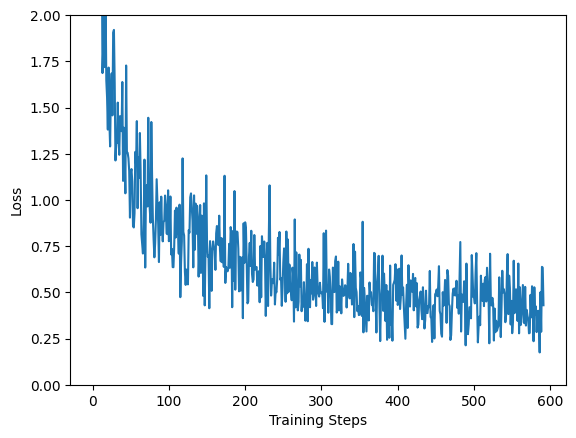

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

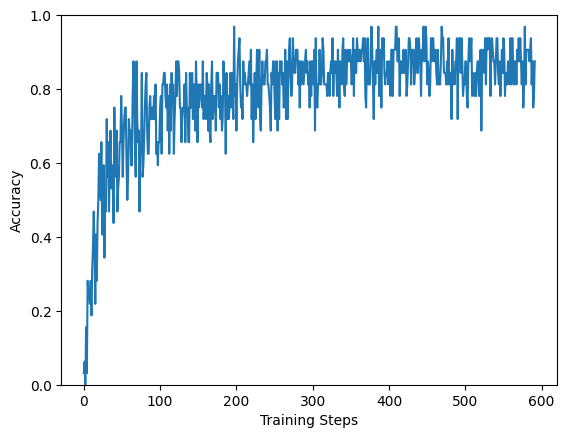

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

1/1 [==============================] - 5s 5s/step


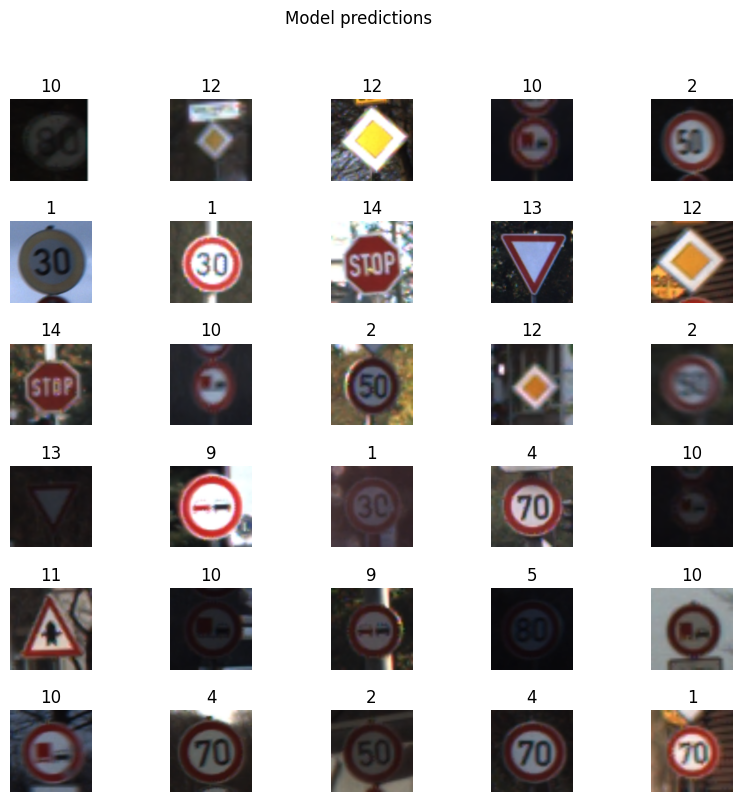

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

My new model works perfectly, we can verify it with th graph of accuracy but also with the response in the images. Know we're gonna save it for the problem 2. 

In [ ]:
import flatbuffers
# Convert the model (note: we are converting the model directly from the "model" variable)
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
print(1)
# Let's save the model as "model_2.tflite"
tflite_model2_path = os.path.join(os.getcwd(),'saved_tflite_models','model_2.tflite')
with open(tflite_model2_path, 'wb') as f:

  f.write(tflite_model)